In [3]:
import pickle
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import plot_importance,plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use({'figure.figsize':(15,10)})

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [4]:
df = pd.read_csv('data/bilibili_rank100_data.csv')

## 数据预处理

In [5]:
#按标题去重
df = df.drop_duplicates(subset=['title'],keep='first',inplace=False)

In [6]:
#缺失值处理
df = df.drop(df[df['time']>1000].index)
df[df.isnull().values==True]

,author,title,tag,partition,funs,like,coins,collect,share,danmu,reply,time,like_rate,views
158,星有野,【我怎么才能让你相信国创动画】,NaN,guochuang,2061928,253632,112476,42338,8076,6495,5382,109.300000,0.105747,2398481
5503,是阿胜呀-,熊出没四个穿帮镜头,NaN,guochuang,325,994,71,629,9,10,10,161.476873,0.001262,787500
5504,次元小主,圆满了！时隔16年，官方终于出又大电影了！,NaN,guochuang,107330,19904,3049,13581,122,172,181,166.302921,0.012275,1621472
5507,-_艾达王_-,《尸兄59》白小飞蜕变为白龙守护者！尸王了结心路历程！人类集结所有战力和尸王决战！！最终大战...,NaN,guochuang,74638,11862,9127,2028,67,404,466,1.323056,0.095506,124202
5518,龙珠哥哥呀,智者的对决，使用脑发达药水后，智商提升100倍，舌战相当激烈！,NaN,guochuang,9541,14408,31,675,8,91,160,5.175903,0.063780,225902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7253,热点库,11岁男孩掏出攒的钱，妈妈瞬间惊呆，网友：成年人都没这么多,NaN,rookie,1035,32260,37,1386,145,96,1318,5.711146,0.045203,713670
7269,生活纪实录,女子为证清白主动要求做DNA，报告出来后，自己都不知谁是孩子爹,NaN,rookie,1242,14821,722,2385,7891,2832,2998,5.794375,0.017965,825002
7270,大富翁酒吧老板-阿杰,我是不是最惨的酒吧老板。我在杭州滨江花了300w开了这么一家酒吧,NaN,rookie,3716,37489,504,3536,1831,828,2566,4.975764,0.034894,1074373
7291,bili_64364371448,江西某211某食堂木桶饭现状,NaN,rookie,26,7859,46,530,1027,130,1086,4.596424,0.018683,420649


In [7]:
#重置索引
df=df.reset_index(drop=True, inplace=False)

In [8]:
#分区按序号编码
def LabelEncoding(df):
    x, dfc = 'partition', df
    key = dfc[x].unique()  # 将唯一值作为关键字
    value = [i for i in range(len(key))]  # 键值
    Dict = dict(zip(key, value))  # 字典，即键值对
    for i in range(len(key)):
        for j in range(dfc.shape[0]):
            if key[i] == dfc[x][j]:
                dfc[x][j] = Dict[key[i]]
    dfc[x] = dfc[x].astype(np.int64)
    return dfc

df = LabelEncoding(df)

In [9]:
df.shape

(5905, 14)

## 划分训练集测试集

In [10]:
df = df.drop(["author","title","tag"],axis = 1)
X = df.drop(["views"],axis = 1)
y = df["views"]
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=99)

In [11]:
X_train.shape, X_test.shape

((4428, 10), (1477, 10))

## 调整XGBoost的参数

首先，调整 `max_depth` 和 `min_child_weight` 参数。稍后，我们将用一个较小的网格来完善这两个选择。我们将使用 `parameters` 来存储更新的参数值，并使用 `scores` 向量来存储MSE值。

In [12]:
n_estimators = 100
learning_rate = 0.1
gamma = 0.1
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 1
reg_lambda = 1

parameters = {}
parameters['n_estimators'] = n_estimators    # 最大的迭代次数,决策树的个数
parameters['learning_rate'] = learning_rate    # 学习速率，控制每次迭代更新权重时的步长
parameters['gamma'] = gamma    # 惩罚项系数，指定节点分裂所需的最小损失函数下降值
parameters['subsample'] = subsample    # 训练每棵树时，使用的数据占全部训练集的比例
parameters['colsample_bytree'] = colsample_bytree    # 随机选择N%特征建立决策树
parameters['reg_alpha'] = reg_alpha    # L1正则化参数
parameters['reg_lambda'] = reg_lambda    # L2正则化参数

scores = []

cv_params = {'max_depth': [2,4,6,8],
             'min_child_weight': [1,3,5,7]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = "reg:squarederror",
                                        seed = 99,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                    ),
                    
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

{'mean_fit_time': array([0.16393857, 0.14458733, 0.14269595, 0.13759389, 0.2210258 ,
       0.22809458, 0.21992283, 0.21381054, 0.31796441, 0.30540786,
       0.28758755, 0.28683753, 0.46921277, 0.40819283, 0.38299212,
       0.38239651]), 'std_fit_time': array([0.02786993, 0.00442478, 0.00139862, 0.00344823, 0.00166341,
       0.00940687, 0.01077617, 0.00268722, 0.00797422, 0.01180642,
       0.00219321, 0.00875536, 0.01614436, 0.01567394, 0.00478118,
       0.00689056]), 'mean_score_time': array([0.00679994, 0.00659471, 0.00630088, 0.00601444, 0.0066052 ,
       0.00679531, 0.00709362, 0.00689321, 0.00700293, 0.00700073,
       0.00660291, 0.00699949, 0.00539026, 0.00649624, 0.00680823,
       0.00709386]), 'std_score_time': array([9.88771065e-04, 3.68965100e-04, 3.90218208e-04, 6.28076695e-04,
       5.91979196e-04, 5.10173925e-04, 4.85149821e-04, 3.77683699e-04,
       6.36350874e-04, 1.76258262e-05, 4.72872767e-04, 1.11358377e-03,
       8.14399249e-04, 8.93066192e-04, 9.77718697e

在上述大网格得到的最佳值基础上，用较小的网格进行细化寻找最优`max_depth`和`min_child_weight`的参数

In [13]:
max_depth = gbm.best_params_['max_depth']
min_child_weight = gbm.best_params_['min_child_weight']
parameters['max_depth'] = max_depth
parameters['min_child_weight'] = min_child_weight
scores.append(gbm.best_score_)

cv_params = {'max_depth': [max_depth-1, max_depth, max_depth+1], 
             'min_child_weight': [min_child_weight-1, min_child_weight-0.5, min_child_weight, min_child_weight+0.5, min_child_weight+1]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = "reg:squarederror",
                                        seed = 99,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                    ),
                   
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

{'mean_fit_time': array([0.24322777, 0.24288874, 0.24389944, 0.24348631, 0.24256968,
       0.28514342, 0.28409209, 0.28195667, 0.28185863, 0.28375177,
       0.33166375, 0.33282537, 0.33282418, 0.33083344, 0.32913327]), 'std_fit_time': array([0.00294819, 0.00466904, 0.00377087, 0.0036707 , 0.00172084,
       0.00376866, 0.00387429, 0.00472774, 0.00497921, 0.00355597,
       0.00517076, 0.0066606 , 0.0045675 , 0.0036174 , 0.00297651]), 'mean_score_time': array([0.00598969, 0.00660367, 0.00699077, 0.00621448, 0.00669203,
       0.00659857, 0.00708728, 0.00658283, 0.00678229, 0.00698156,
       0.00698128, 0.00718045, 0.00738034, 0.0065825 , 0.00698118]), 'std_score_time': array([6.33426945e-04, 8.08339343e-04, 1.15770327e-05, 3.93249851e-04,
       5.96197178e-04, 4.83378711e-04, 2.00235523e-04, 4.88792316e-04,
       3.98755198e-04, 2.78041453e-07, 6.14361702e-07, 3.98993531e-04,
       4.88636109e-04, 4.89103591e-04, 4.10190833e-07]), 'param_max_depth': masked_array(data=[5, 5, 5, 5, 

设置`max_depth`和`min_child_weight`的参数

调整`gamma`参数

In [14]:
max_depth = gbm.best_params_['max_depth']
min_child_weight = gbm.best_params_['min_child_weight']
parameters['max_depth'] = max_depth
parameters['min_child_weight'] = min_child_weight
scores.append(gbm.best_score_)

cv_params = {'gamma': [i/10.0 for i in range(1,10,2)]}

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = "reg:squarederror",
                                        seed = 99,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                    ),
                   
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

{'mean_fit_time': array([0.24834499, 0.24784975, 0.24874506, 0.24804726, 0.24894376]), 'std_fit_time': array([0.00324498, 0.00314198, 0.00261607, 0.00149705, 0.00079669]), 'mean_score_time': array([0.00698142, 0.00678191, 0.00697913, 0.00698142, 0.00698161]), 'std_score_time': array([4.62310777e-07, 3.98803053e-04, 4.85484863e-06, 5.91739352e-07,
       4.76837158e-07]), 'param_gamma': masked_array(data=[0.1, 0.3, 0.5, 0.7, 0.9],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.1}, {'gamma': 0.3}, {'gamma': 0.5}, {'gamma': 0.7}, {'gamma': 0.9}], 'split0_test_score': array([0.90479934, 0.90479934, 0.90479934, 0.90479934, 0.90479934]), 'split1_test_score': array([0.95114859, 0.95114859, 0.95114859, 0.95114859, 0.95114859]), 'split2_test_score': array([0.97161909, 0.97161909, 0.97161909, 0.97161909, 0.97161909]), 'split3_test_score': array([0.90023541, 0.90023541, 0.90023541, 0.90023541, 0.90023541]), 'split4_t

设置`gamma`参数

调整`learning_rate`和`n_estimators`参数

In [15]:
gamma = gbm.best_params_['gamma']
parameters['gamma'] = gamma
scores.append(gbm.best_score_)

cv_params = {'learning_rate':[i/10.0 for i in range(1,4)],
             'n_estimators':range(50,500,50)
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = "reg:squarederror",
                                        seed = 99,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        gamma = gamma,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                    ),
                   
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

{'mean_fit_time': array([0.13384857, 0.24944615, 0.36433611, 0.48252974, 0.59523134,
       0.71991029, 0.83898702, 0.95339141, 1.07347383, 0.13115392,
       0.25143814, 0.37082186, 0.49121127, 0.61956635, 0.75122452,
       0.87302518, 1.00315819, 1.12882948, 0.13424788, 0.25323381,
       0.38139839, 0.51624141, 0.6525836 , 0.78722653, 0.91408777,
       1.03796701, 1.16643195]), 'std_fit_time': array([0.00182805, 0.00207941, 0.00200947, 0.00446853, 0.00619337,
       0.00742856, 0.009814  , 0.00613617, 0.00859039, 0.00341305,
       0.00123639, 0.00609329, 0.00443088, 0.0071569 , 0.00763298,
       0.00507706, 0.0079527 , 0.01076899, 0.00184622, 0.00115211,
       0.00565931, 0.00667901, 0.00852423, 0.00604215, 0.0054642 ,
       0.00607353, 0.00965673]), 'mean_score_time': array([0.00698113, 0.00678234, 0.0072824 , 0.00698113, 0.00777874,
       0.00757732, 0.00638337, 0.00558553, 0.00598469, 0.00658221,
       0.00698137, 0.00678124, 0.00738015, 0.007482  , 0.00638337,
       0.0

设置`learning_rate`和`n_estimators`参数

调整`subsample`和`colsample_bytree`参数

In [16]:
learning_rate = gbm.best_params_['learning_rate']
n_estimators = gbm.best_params_['n_estimators']
parameters['learning_rate'] = learning_rate
parameters['n_estimators'] = n_estimators
scores.append(gbm.best_score_)

cv_params = {'subsample': [i/10.0 for i in range(6,11)],
             'colsample_bytree': [i/10.0 for i in range(6,11)]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = "reg:squarederror",
                                        seed = 99,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        gamma = gamma,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                    ),
                   
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

{'mean_fit_time': array([0.99918933, 1.04838343, 1.10446897, 1.1554738 , 1.09792194,
       1.00750184, 1.05872097, 1.12609596, 1.17990165, 1.12591014,
       1.03839188, 1.09759879, 1.15470991, 1.20668712, 1.14290051,
       1.05820441, 1.11960273, 1.17440958, 1.24808674, 1.17271671,
       1.08403692, 1.15887899, 1.2653903 , 1.27820234, 1.19830313]), 'std_fit_time': array([0.00665783, 0.00440984, 0.00418051, 0.01048494, 0.01853008,
       0.00111755, 0.00422974, 0.01046539, 0.01724376, 0.00880773,
       0.00356147, 0.00374363, 0.00848141, 0.0093333 , 0.01472441,
       0.01003462, 0.00499493, 0.01251596, 0.00697863, 0.00665982,
       0.00401904, 0.00609867, 0.03654922, 0.00957309, 0.01417662]), 'mean_score_time': array([0.00529571, 0.00599084, 0.00620279, 0.0060019 , 0.00579786,
       0.00599236, 0.00609055, 0.00570707, 0.0058898 , 0.00599847,
       0.00599346, 0.00599856, 0.00629468, 0.00629969, 0.00639515,
       0.00659161, 0.00600314, 0.0065906 , 0.0068996 , 0.00639019,
     

在上述大网格得到的最佳值基础上，用较小的网格进行细化寻找最优`subsample`和`colsample_bytree`参数

In [17]:
subsample = gbm.best_params_['subsample']
colsample_bytree = gbm.best_params_['colsample_bytree']
parameters['subsample'] = subsample
parameters['colsample_bytree'] = colsample_bytree
scores.append(gbm.best_score_)

cv_params = {'subsample': [i/100.0 for i in range(int((subsample-0.1)*100.0), min(int((subsample+0.1)*100),105) , 5)],
             'colsample_bytree': [i/100.0 for i in range(int((colsample_bytree-0.1)*100.0), min(int((subsample+0.1)*100),105), 5)]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = "reg:squarederror",
                                        seed = 99,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        gamma = gamma,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                    ),
                   
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

{'mean_fit_time': array([1.19533429, 1.2396996 , 1.27550502, 1.32199225, 1.24360414,
       1.27419801, 1.30960283, 1.32500706]), 'std_fit_time': array([0.01501143, 0.00931727, 0.01160489, 0.01300528, 0.00602716,
       0.00578182, 0.00524721, 0.00948013]), 'mean_score_time': array([0.00658455, 0.0066956 , 0.00699296, 0.00649495, 0.00680599,
       0.00690508, 0.0071043 , 0.00739436]), 'std_score_time': array([0.00049267, 0.00040676, 0.00063893, 0.0004311 , 0.00040273,
       0.00048517, 0.00102104, 0.00047758]), 'param_colsample_bytree': masked_array(data=[0.8, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85, 0.85],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.7, 0.75, 0.8, 0.85, 0.7, 0.75, 0.8, 0.85],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'colsample_bytree': 0.8, 'subsample': 0.7}, 

设置`colsample_bytree`和`subsample`参数

调整`reg_alpha`和`reg_lambda`参数

`reg_alpha`控制L1正则化，`reg_lambda`控制L2正则化

In [18]:
colsample_bytree = gbm.best_params_['colsample_bytree']
subsample = gbm.best_params_['subsample']
parameters['colsample_bytree'] = colsample_bytree
parameters['subsample'] = subsample
scores.append(gbm.best_score_)

cv_params = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100], 
             'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = "reg:squarederror",
                                        seed = 99,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        gamma = gamma,
                                        colsample_bytree = colsample_bytree,
                                        subsample = subsample,
                                    ),
                   
                    param_grid = cv_params,
                    cv = 5,
)

gbm.fit(X_train,y_train)
print(gbm.cv_results_)
print("Best parameters %s" %gbm.best_params_)
print("Best score %s" %gbm.best_score_)

{'mean_fit_time': array([1.24111733, 1.24099469, 1.24569378, 1.24281797, 1.29119663,
       1.24240117, 1.23830032, 1.24319906, 1.24030695, 1.28670764,
       1.23710165, 1.23730664, 1.24279399, 1.24051342, 1.28749361,
       1.23995419, 1.23737335, 1.24009585, 1.23951511, 1.28790283,
       1.23780484, 1.23690534, 1.24080071, 1.24060135, 1.29080429]), 'std_fit_time': array([0.00679982, 0.00142028, 0.00525616, 0.00464881, 0.00543061,
       0.00413194, 0.00541203, 0.00480586, 0.00376601, 0.01491563,
       0.00317033, 0.00788076, 0.00529277, 0.00208486, 0.00602222,
       0.00148935, 0.01202256, 0.00719314, 0.00221941, 0.00577309,
       0.00430153, 0.0055083 , 0.00242636, 0.00265744, 0.00898312]), 'mean_score_time': array([0.00659771, 0.00660596, 0.0072978 , 0.00699539, 0.0068975 ,
       0.0074049 , 0.00670791, 0.00719185, 0.00650377, 0.00699363,
       0.00660582, 0.0067081 , 0.00679178, 0.00688891, 0.00658913,
       0.00658841, 0.00680432, 0.00699635, 0.00668998, 0.00659676,
     

设置`reg_alpha`和`reg_lambda`参数

In [19]:
reg_alpha = gbm.best_params_['reg_alpha']
reg_lambda = gbm.best_params_['reg_lambda']
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
scores.append(gbm.best_score_)

## 打印最终参数和获得的分数

确保分数随着每次迭代而增加

In [20]:
print(parameters)
print(scores)

{'n_estimators': 450, 'learning_rate': 0.1, 'gamma': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_alpha': 100, 'reg_lambda': 1e-05, 'max_depth': 5, 'min_child_weight': 6}
[0.9381797366329888, 0.9392292025919275, 0.9392292025919275, 0.9563371042431406, 0.9597499128811924, 0.9580457076105724, 0.9590997258289041]


创建XGBoost的DMatrix

In [21]:
trainDMat = xgb.DMatrix(data = X_train, label = y_train)
testDMat = xgb.DMatrix(data = X_test, label = y_test)

通过交叉验证，找到最好的树


降低学习率并设置一个大的num_boost_round超参数以确保收敛

In [22]:
learning_rate = 0.05
parameters['eta'] = learning_rate

num_boost_round = 3000
early_stopping_rounds = 20

xgbCV = xgb.cv(
    params = parameters, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 5,
    metrics = {'rmse'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,
    seed = 99 
)

[14:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  Thi

确定最终XGBoost模型

In [23]:
num_boost_round = len(xgbCV)
parameters['eval_metric'] = 'rmse'

xgbFinal = xgb.train(
    params = parameters,
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    evals = [(trainDMat, 'train'), 
             (testDMat, 'eval')]
)

[14:46:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:965538.50000	eval-rmse:1017365.62500
[1]	train-rmse:884559.00000	eval-rmse:934386.56250
[2]	train-rmse:806989.81250	eval-rmse:856963.68750
[3]	train-rmse:734917.62500	eval-rmse:780249.00000
[4]	train-rmse:671201.25000	eval-rmse:716673.06250
[5]	train-rmse:618881.56250	eval-rmse:660595.75000
[6]	train-rmse:574810.81250	eval-rmse:616440.50000
[7]	train-rmse:538936.00000	eval-rmse:587578.87500
[8]	train-rmse:507511.40625	eval-rmse:558231.31250
[9]	train-rmse:466293.78125	eval-rmse:522184.31250
[10]	train-rmse:431746.00000	eval-rmse:490631.37500
[11]	train-rmse:

绘制特征重要性图并打印数值

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

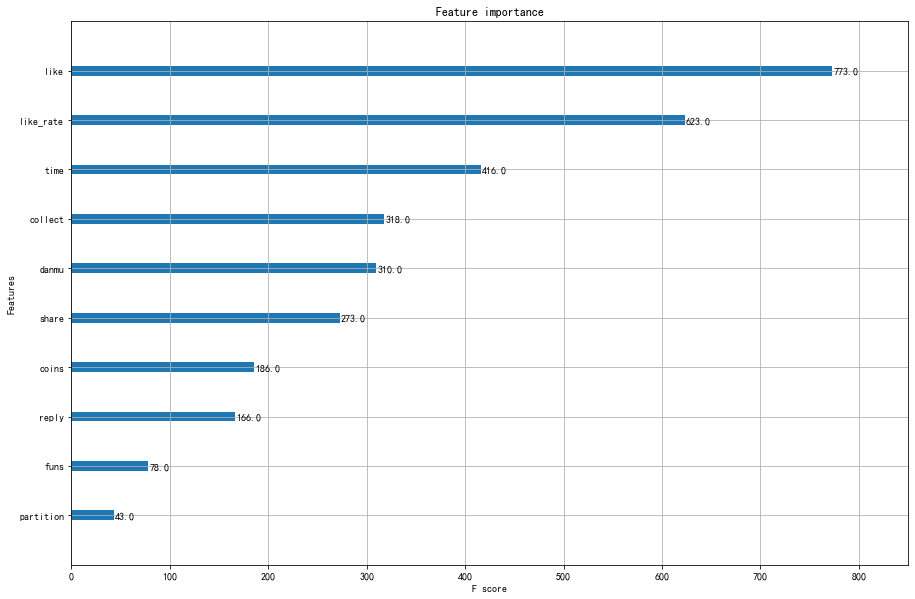

In [24]:
xgb.plot_importance(xgbFinal)

#### 对训练集和测试集进行预测

In [29]:
xgbFinal_train_preds = xgbFinal.predict(trainDMat)
xgbFinal_test_preds = xgbFinal.predict(testDMat)

In [30]:
print(xgbFinal_train_preds.shape)
print(xgbFinal_test_preds.shape)

(4428,)
(1477,)


#### 计算MSE均方误差和RMSE均方根误差

In [31]:
print("\nModel Report")
print("MSE Train : %f" % mean_squared_error(y_train, xgbFinal_train_preds))
print("MSE Test: %f" % mean_squared_error(y_test, xgbFinal_test_preds))
print("RMSE Train: %f" % mean_squared_error(y_train, xgbFinal_train_preds)**0.5)
print("RMSE Test: %f" % mean_squared_error(y_test, xgbFinal_test_preds)**0.5)


Model Report
MSE Train : 1367053527.560016
MSE Test: 25397408806.300060
RMSE Train: 36973.686962
RMSE Test: 159365.645000


将模型打包成pkl文件

In [ ]:
pickle.dump(xgbFinal, open("xgbFinal.pkl", "wb"))

In [ ]:
train_preds = pd.DataFrame(xgbFinal_train_preds)
test_preds = pd.DataFrame(xgbFinal_test_preds)
train_preds.columns = ['views']
test_preds.columns = ['views']

In [ ]:
# train_preds.to_csv('XGBoost_Train_Preds.csv', sep=',')
# test_preds.to_csv('XGBoost_Test_Preds.csv', sep=',')